In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
%matplotlib inline

In [2]:
#import the dataset from the csv file 
data = pd.read_csv('creditcard.csv')

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [3]:
print('Number of training exapmles: {}\nNumber of features: {}'.format(data.shape[0], data.shape[1]))

Number of training exapmles: 284807
Number of features: 31


In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Time: Number of seconds elapsed between this transaction and the first transaction in the dataset.

In [5]:
# 15% of data, remove this line to use all the data, to increase speed and get better visual result
data = data.sample(frac = 0.15, random_state=1)

In [6]:
print('Number of training exapmles: {}\nNumber of features: {}'.format(data.shape[0], data.shape[1]))

Number of training exapmles: 42721
Number of features: 31


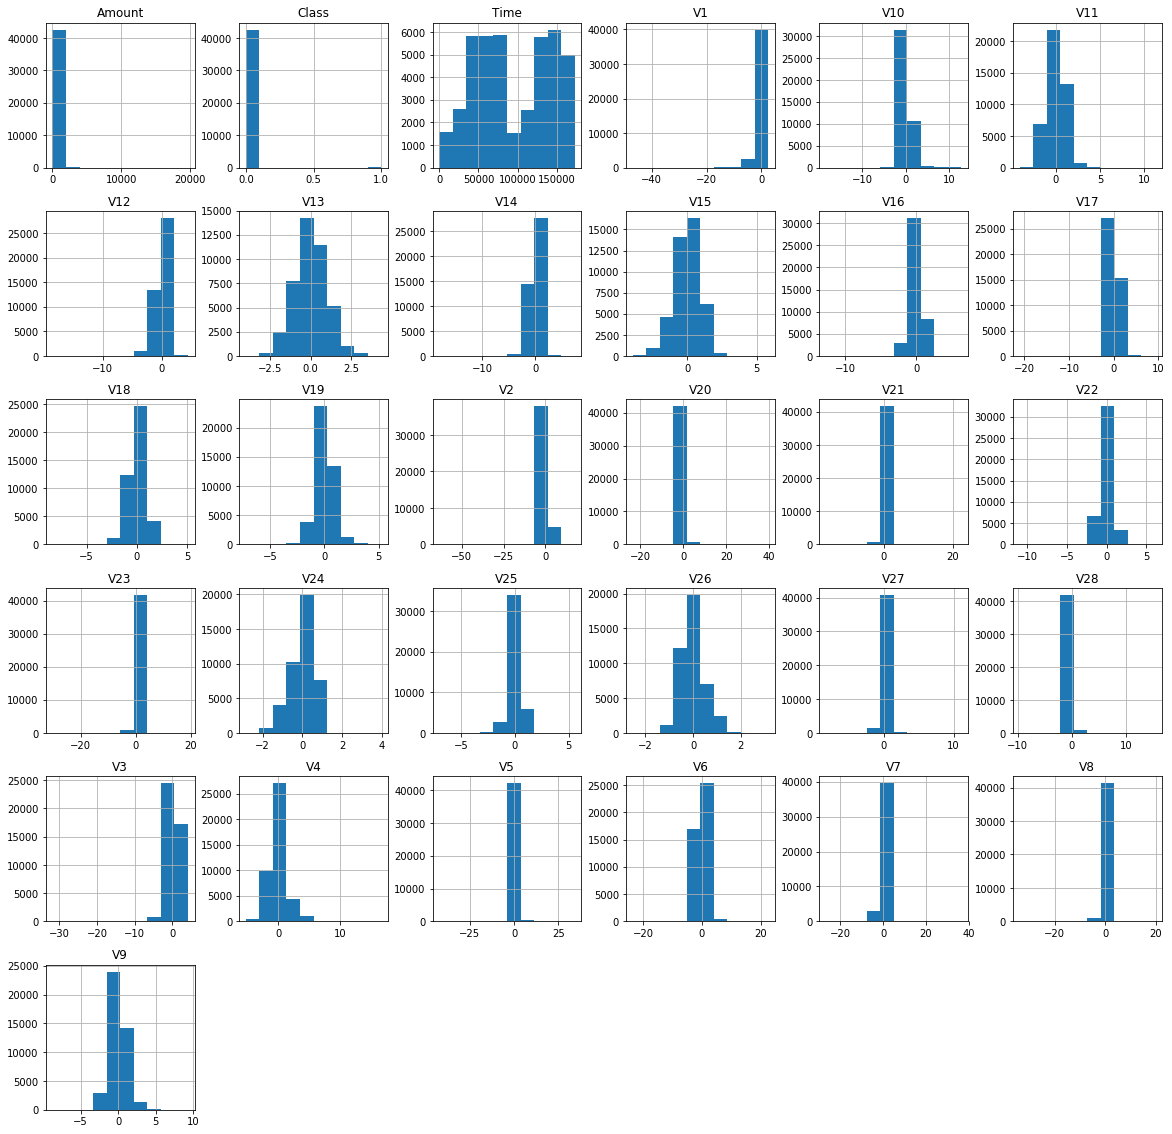

In [7]:
# plt parameters
data.hist(figsize=(20, 20))
plt.show()

In [8]:
# Dtermine number of fraud cases in dataset
Fraud = data[data['Class'] == 1]
Valid = data[data['Class'] == 0]

outlier_fraction = len(Fraud) / len(Valid)
print('Fraud to valid % : {}'.format(outlier_fraction*100))

Fraud to valid % : 0.16177435993622807


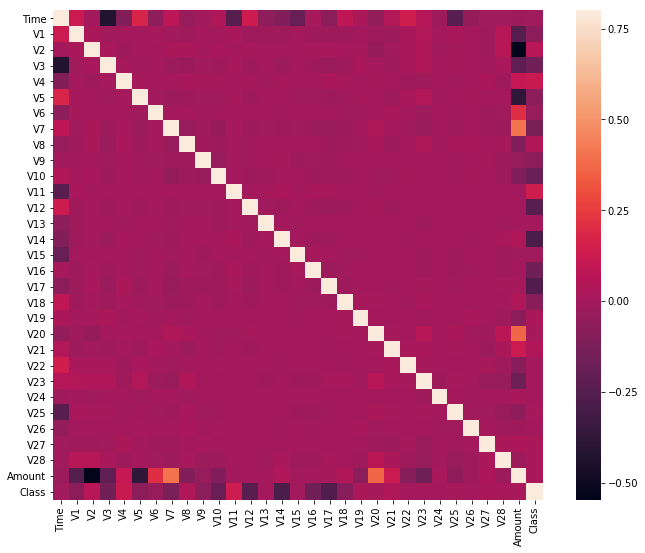

In [9]:
# correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.8, square=True)

In [10]:
# get all the columns from the DataFrame
columns = data.columns.tolist()

#Filter the columns to data we do not want
X = data.drop('Class', axis=1)

# Store the cariable we'll be predicting on
Y = data['Class']

In [11]:
# print the shapes of x and y
print(X.shape, Y.shape)

(42721, 30) (42721,)


In [12]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [13]:
# define random states
state = 1

# define outlier detection tools to be compared
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(X),
                                        contamination=outlier_fraction,
                                        random_state=state),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=20,
        contamination=outlier_fraction)}

In [14]:
# Fit the model
plt.figure(figsize=(9, 7))
n_outliers = len(Fraud)


for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
    
    # Reshape the prediction values to 0 for valid, 1 for fraud. 
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    n_errors = (y_pred != Y).sum()
    
    # Run classification metrics
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))

/home/naeem/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/naeem/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Isolation Forest: 105
0.997542192364411
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42652
           1       0.24      0.25      0.24        69

   micro avg       1.00      1.00      1.00     42721
   macro avg       0.62      0.62      0.62     42721
weighted avg       1.00      1.00      1.00     42721

Local Outlier Factor: 137
0.9967931462278504
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42652
           1       0.01      0.01      0.01        69

   micro avg       1.00      1.00      1.00     42721
   macro avg       0.51      0.51      0.51     42721
weighted avg       1.00      1.00      1.00     42721



<Figure size 648x504 with 0 Axes>